# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
def pn(x):
  print(x,"\n")

def show():
  return plt.figure()

def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

Unnamed: 0           0
Make                 0
Make_Year            0
Color                0
Body_Type            0
Mileage_Run          0
No_of_Owners         0
Seating_Capacity     0
Fuel_Type            0
Transmission         0
Transmission_Type    0
Price                0
dtype: int64 

[5 7 8 6 4] 

5    930
7     39
8      5
6      1
4      1
Name: Seating_Capacity, dtype: int64 

['5-seater' '7-seater' '8-seater' '6-seater' '4-seater'] 



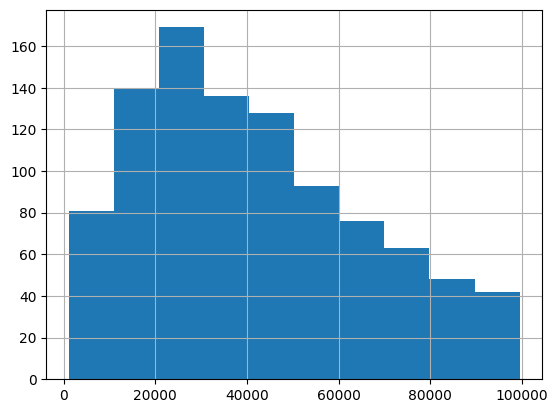

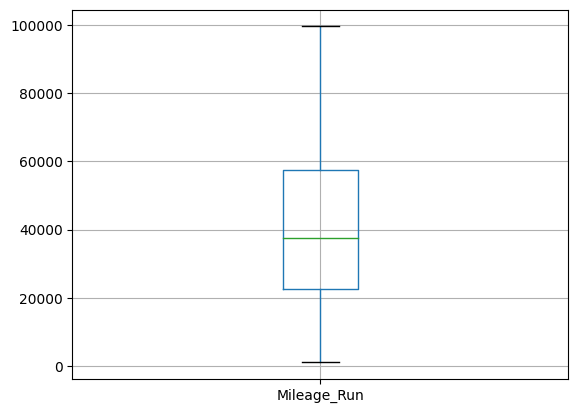

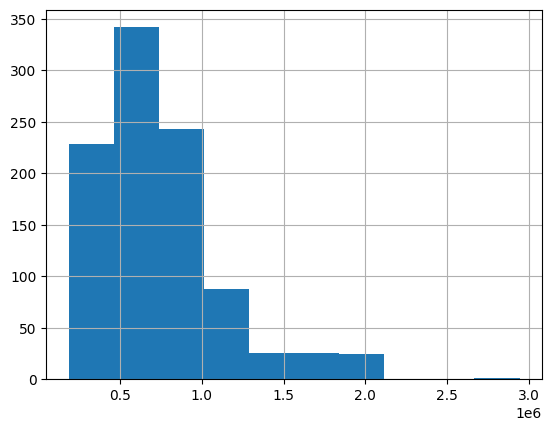

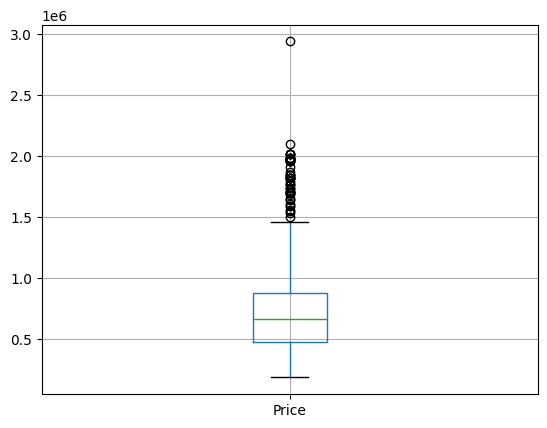

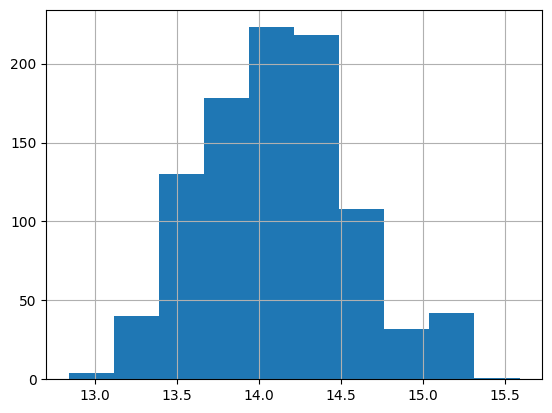

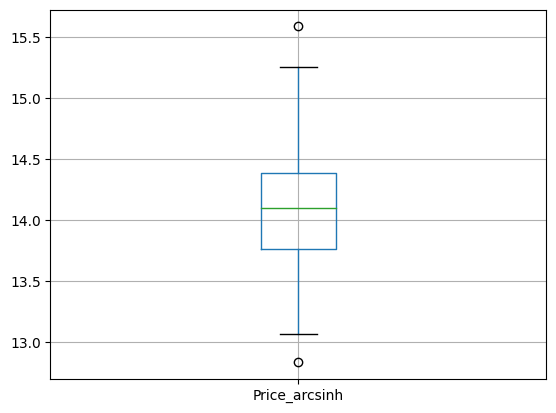

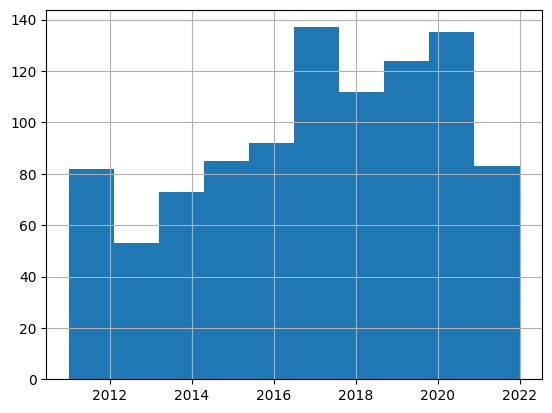

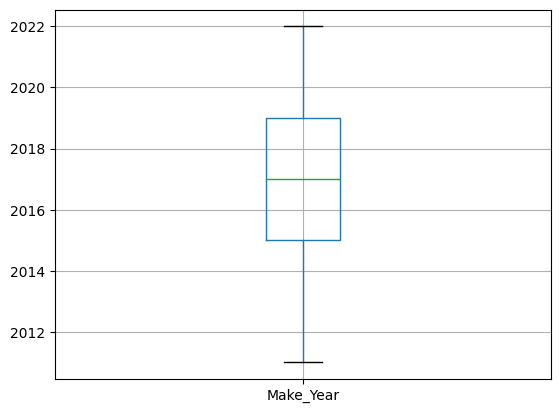

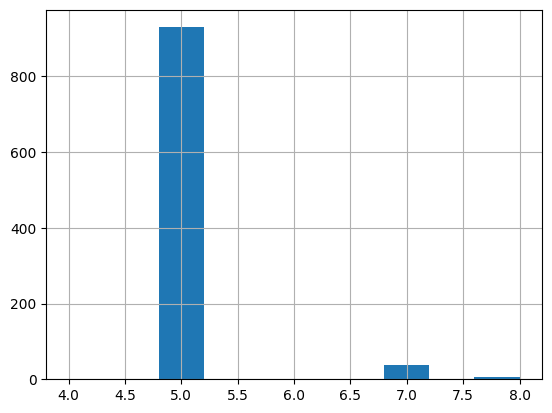

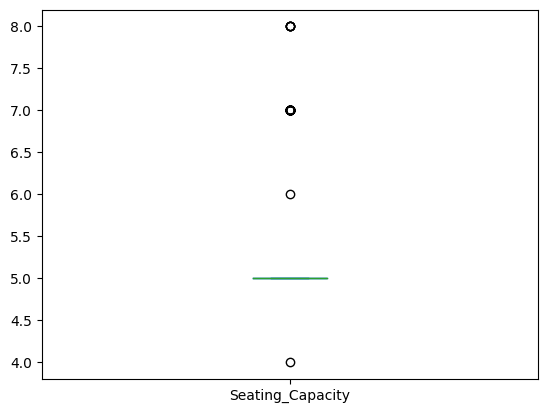

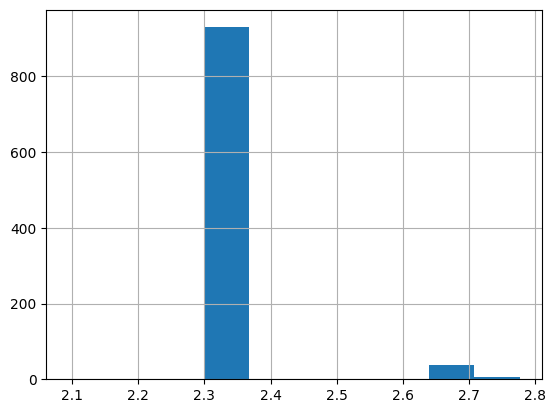

In [221]:
#1.1
df = pd.read_csv('/content/cars_hw.csv')
pn(df.isnull().sum())


df['Mileage_Run'].hist()
show()
df.boxplot(column = 'Mileage_Run')
show()

df['Price'].hist()
show()
df.boxplot(column = 'Price')
show()

#df['Price_wind'] = df['Price']
#windsorize(df['Price_wind'])
#Every price value for MG motors was an outlier so windsorizing turned all of them
#to the upper whisker value which ruined KDE plots. Plus arcsinh got rid of almost
#all the outliers
df['Price_arcsinh'] = np.arcsinh(df['Price'])

df['Price_arcsinh'].hist()
show()
df.boxplot(column = "Price_arcsinh")
show()

df['Make_Year'].hist()
show()
df.boxplot(column = "Make_Year")
show()

pn(df['Seating_Capacity'].unique())
pn(df['Seating_Capacity'].value_counts())
df['Seating_Capacity'].hist()
show()
df['Seating_Capacity'].plot.box()
show()

df['SC_arcsinh'] = np.arcsinh(df['Seating_Capacity'])
df['SC_arcsinh'].hist()

#Treating Seating_Capacity as a Categorical Variable because windsorizing would
#turn everything to 5 either way effectively making the whole column useless
var = 'SC_Cat'
df[var] = df['Seating_Capacity']
df[var] = df[var].replace(4,'4-seater')
df[var] = df[var].replace(5,'5-seater')
df[var] = df[var].replace(6,'6-seater')
df[var] = df[var].replace(7,'7-seater')
df[var] = df[var].replace(8,'8-seater')
pn(df[var].unique())

count    9.760000e+02
mean     7.410195e+05
std      3.673234e+05
min      1.880000e+05
25%      4.757500e+05
50%      6.665000e+05
75%      8.830000e+05
max      2.941000e+06
Name: Price, dtype: float64 

               Price                                                    \
               count          mean           std        min        25%   
Make                                                                     
Chevrolet        6.0  4.535000e+05  2.466064e+05   267000.0   288500.0   
Datsun           3.0  2.896667e+05  1.050397e+04   279000.0   284500.0   
Ford            52.0  7.211731e+05  1.409277e+05   290000.0   635000.0   
Honda           73.0  7.989726e+05  2.665091e+05   316000.0   581000.0   
Hyundai        305.0  6.918918e+05  2.791597e+05   248000.0   485000.0   
Jeep             4.0  1.499500e+06  1.525134e+05  1290000.0  1447500.0   
Kia              8.0  1.614750e+06  1.190567e+05  1369000.0  1579000.0   
MG Motors       35.0  1.869457e+06  1.216611e+05  1589

<Figure size 640x480 with 0 Axes>

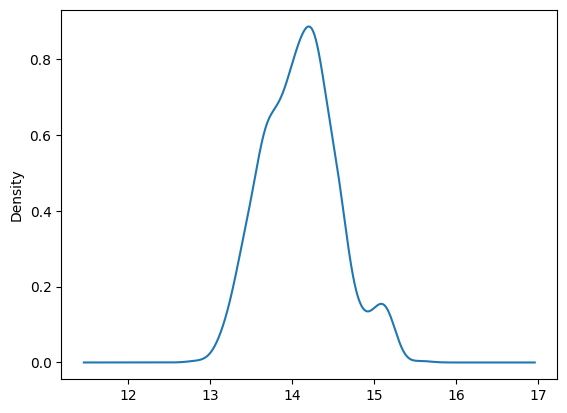

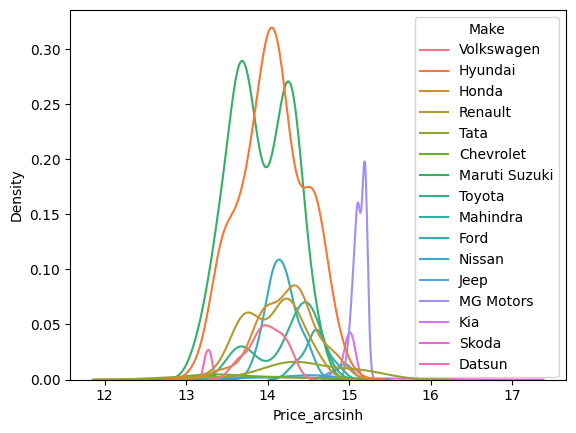

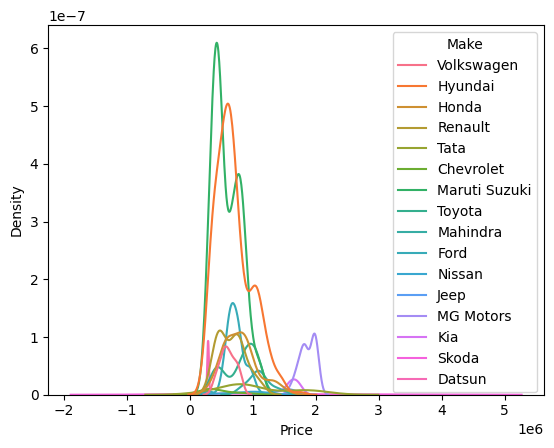

<Figure size 640x480 with 0 Axes>

In [222]:
#1.2
pn(df['Price'].describe())
df['Price_arcsinh'].plot.density()
show()

pn(df.loc[:,['Make','Price']].groupby('Make').describe())


sns.kdeplot(data = df, x = 'Price_arcsinh',hue='Make')
show()
sns.kdeplot(data = df, x = 'Price',hue='Make')
show()

There may be a mistake with the pricing of all the cars as all of them seem very expensive with cars that are valued over a million dollars. I think decimal placement may have been messed up. I am going to assume this is not the case. Brands such as Jeep, Kia, MG Motors, Mahindra, Skoda, and Tata have an average price of 7 figures. Specifically, MG Motors has the highest average with a lower standard deviation and a median near the average, therefore, all of there cars are highly valued. In general the prices average around $740,000 dollars, however brands such as MG Motors shoot this value up.

In [223]:
#1.3
y = df["Price"]

X = df.drop(['Price','Unnamed: 0','Seating_Capacity','Price_arcsinh','SC_arcsinh',],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [224]:
from sklearn import linear_model
from sklearn.metrics import r2_score
#1.4
X_train_lm_N = X_train[['Make_Year','Mileage_Run']]
X_test_lm_N = X_test[['Make_Year','Mileage_Run']]
X_cat = X.drop(['Make_Year','Mileage_Run'],axis=1)
X_cat = pd.get_dummies(data = X_cat,drop_first=True)
X_train_lm_cat, X_test_lm_cat, y_train, y_test = train_test_split(X_cat, y, test_size=0.2, random_state=50)
X_n = X[['Make_Year','Mileage_Run']]
X_all = pd.concat([X_n, X_cat], axis=1)
X_train_lm_all, X_test_lm_all, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=50)

def RMSE(X_train,X_test,y_train,y_test,model,depth):
  N_test = len(y_test)
  if(model == "linear"):
    predicted = regu_Lin_Reg(X_train,X_test,y_train,y_test)
  elif(model == "tree"):
    predicted = treeRegressor(X_train,X_test,y_train,y_test,depth)
  residuals = y_test - predicted
  SSE = np.sum((residuals)**2)
  RMSE = (SSE/N_test)**(1/2)
  return RMSE

def R2(X_train,X_test,y_train,y_test,model,depth):
  if(model == "linear"):
    predicted = regu_Lin_Reg(X_train,X_test,y_train,y_test)
  elif(model == "tree"):
    predicted = treeRegressor(X_train,X_test,y_train,y_test,depth)
  r2 = r2_score(y_test, predicted)
  return r2

def regu_Lin_Reg(X_train,X_test,y_train,y_test):
  regr = linear_model.LinearRegression()
  regr.fit(X_train,y_train)
  predicted = regr.predict(X_test)
  return predicted

def score(R2,RMSE):
  pn('R2: ' +str(R2))
  pn('RMSE: '+str(RMSE))

R2_N = R2(X_train_lm_N,X_test_lm_N,y_train,y_test,"linear",0)
RMSE_N = RMSE(X_train_lm_N,X_test_lm_N,y_train,y_test,"linear",0)
pn("Only Numeric: ")
score(R2_N,RMSE_N)

R2_cat = R2(X_train_lm_cat,X_test_lm_cat,y_train,y_test,"linear",0)
RMSE_cat = RMSE(X_train_lm_cat,X_test_lm_cat,y_train,y_test,"linear",0)
pn("Only Categorical: ")
score(R2_cat,RMSE_cat)

R2_all = R2(X_train_lm_all,X_test_lm_all,y_train,y_test,"linear",0)
RMSE_all = RMSE(X_train_lm_all,X_test_lm_all,y_train,y_test,"linear",0)
pn("Categorical and Numeric: ")
score(R2_all,RMSE_all)

Only Numeric:  

R2: 0.2612724474191731 

RMSE: 319650.67640721315 

Only Categorical:  

R2: 0.6063025657245174 

RMSE: 233353.7429870334 

Categorical and Numeric:  

R2: 0.7425257523395146 

RMSE: 188712.37396303014 



The R2 using the numeric variables was 0.266 and the RMSE was 319651. The R2 using the categorical variables was 0.606 and the RMSE was 233354. The model using only categorical variables performs better. The R2 using the numeric and categorical variables was 0.743 and the RMSE was 188712. This joint model performs better than both of the previous models. Specifically, its R2 value is 0.477 higher than the numeric model and 0.137 higher than the categorical model making its predictions the closest to the test values.

In [225]:
#1.5
def expander(data,exp):
  expander = PolynomialFeatures(degree=exp,include_bias=False)
  Z_train = expander.fit_transform(data)
  names = expander.get_feature_names_out()
  expanded_df = pd.DataFrame(data=Z_train, columns = names)
  return expanded_df

X_train_exp2 = expander(X_train_lm_all,2)
X_test_exp2 = expander(X_test_lm_all,2)
R2_exp2 = R2(X_train_exp2,X_test_exp2,y_train,y_test,"linear",0)
RMSE_exp2 = RMSE(X_train_exp2,X_test_exp2,y_train,y_test,"linear",0)
pn("Degree of 2: ")
score(R2_exp2,RMSE_exp2)

X_train_exp3 = expander(X_train_lm_all,3)
X_test_exp3 = expander(X_test_lm_all,3)
R2_exp3 = R2(X_train_exp3,X_test_exp3,y_train,y_test,"linear",0)
RMSE_exp3 = RMSE(X_train_exp3,X_test_exp3,y_train,y_test,"linear",0)
pn("Degree of 3: ")
score(R2_exp3,RMSE_exp3)

Degree of 2:  

R2: -165.4215297050634 

RMSE: 4797756.847026268 

Degree of 3:  

R2: -29439520.70459941 

RMSE: 2017896346.5286496 



 As the degree of expansion increases, R2 decreases and RMSE increases. R2 goes negative as soon as the degree of expansion is 2. The best values for R2 and RMSE with expanded features is when the degree of expansion is 2. Specifically, the R2 is -165.4 and the RMSE is 4797757. This model is significantly worse than the best model for part 3 which was the model using both categorical and numeric variables with no expansion. This model had a R2 of 0.743 and a RMSE of 188712.

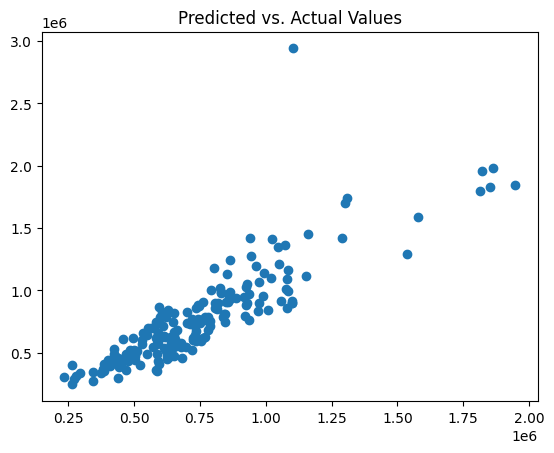

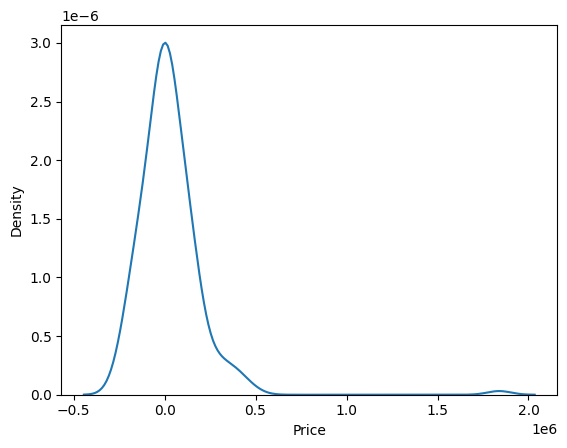

In [226]:
#1.6
predicted_values = regu_Lin_Reg(X_train_lm_all,X_test_lm_all,y_train,y_test,)
plt.scatter(x=predicted_values,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

residuals = y_test - predicted_values
sns.kdeplot(residuals)
plt.show()

The predicted and actual values do roughly line up along the diagonal. There is one outlier where the actual value was around 3,000,000 but the predicted value was around 1,200,000. The residuals do roughly form a bell curve around zero, however there is a small density near the price of 1,700,000 which is probably the outlier. The model does a decent job in predicting the prices as the predicted and actual values roughly line up along the diagonal and there is a bell curve around 0, however, the model is not ideal as it does not account for outliers. This is reasonable because outliers tend to mess up prediction models anyways.

In [227]:
#1.7

def treeRegressor(X_train,X_test,y_train,y_test,depth):
  model = tree.DecisionTreeRegressor(max_depth=depth)
  cart = model.fit(X_train, y_train)
  predicted = cart.predict(X_test)
  return predicted


R2_depth3 = R2(X_train_lm_all,X_test_lm_all,y_train,y_test,"tree",3)
RMSE_depth3 = RMSE(X_train_lm_all,X_test_lm_all,y_train,y_test,"tree",3)
pn("Depth of 3: ")
score(R2_depth3,RMSE_depth3)

R2_depth5 = R2(X_train_lm_all,X_test_lm_all,y_train,y_test,"tree",5)
RMSE_depth5 = RMSE(X_train_lm_all,X_test_lm_all,y_train,y_test,"tree",5)
pn("Depth of 5: ")
score(R2_depth5,RMSE_depth5)

R2_depth10 = R2(X_train_lm_all,X_test_lm_all,y_train,y_test,"tree",10)
RMSE_depth10 = RMSE(X_train_lm_all,X_test_lm_all,y_train,y_test,"tree",10)
pn("Depth of 10: ")
score(R2_depth10,RMSE_depth10)

R2_depth20 = R2(X_train_lm_all,X_test_lm_all,y_train,y_test,"tree",20)
RMSE_depth20 = RMSE(X_train_lm_all,X_test_lm_all,y_train,y_test,"tree",20)
pn("Depth of 20: ")
score(R2_depth20,RMSE_depth20)

Depth of 3:  

R2: 0.636424196804323 

RMSE: 224249.23243372503 

Depth of 5:  

R2: 0.6636791689863217 

RMSE: 215680.24233313274 

Depth of 10:  

R2: 0.6950864093492772 

RMSE: 202762.01729149307 

Depth of 20:  

R2: 0.6701558156807581 

RMSE: 210599.34213611227 



The tree with a depth of 10 gives the best results with an R2 of 0.705 and and RMSE of 206440. (Although these values varied slightly when I kept hitting run for some reason. However the depth of 10 still appeared to give the best results.)

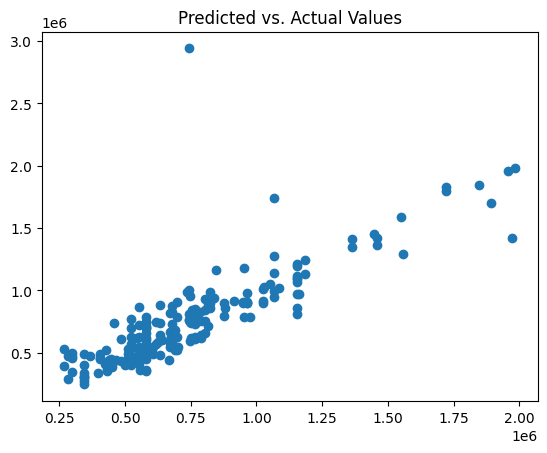

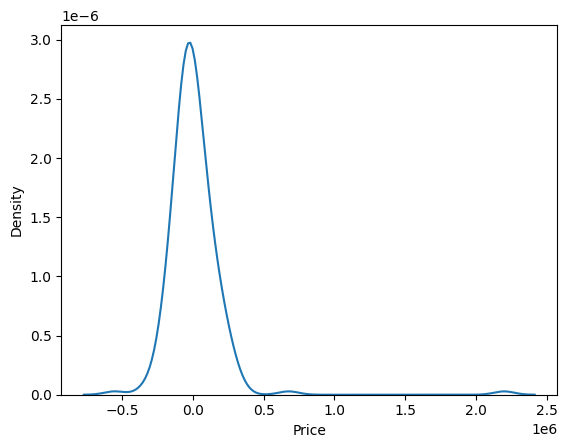

In [228]:
#1.8
predicted_values = treeRegressor(X_train_lm_all,X_test_lm_all,y_train,y_test,10)
plt.scatter(x=predicted_values,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

residuals = y_test - predicted_values
sns.kdeplot(residuals)
plt.show()

The predicted and true values do roughly line up on the diagonal with the exception of the outlier. The residuals also look roughly bell shaped around zero with the exception of a small curve to the far right which is probably caused by the outlier.

1.9)

The linear model using both categorical and numeric variables with no expansion has the slightly better perfomance on the test set. Specifically, its R2 is 0.0375 higher than the tree model's R2.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

Load the wages_hw.csv file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

In [245]:
#3.1
df = pd.read_csv('/content/contraception_hw.csv')
df = df.drop('Unnamed: 0',axis=1)
method_counts = df['method'].value_counts()
pn(method_counts)
cross_tab = pd.crosstab(df['method'], df['numberChildren'])
pn(cross_tab)


1    629
3    511
2    333
Name: method, dtype: int64 

numberChildren  0    1    2    3   4   5   6   7   8   9   10  11  12  13  16
method                                                                       
1               95  143  114   70  57  44  35  18  29   5   9   6   4   0   0
2                0   46   56   70  62  36  27  19   9   3   2   2   0   1   0
3                2   87  106  119  78  55  30  12   9   8   0   3   0   1   1 



There tend to be more couples that used contraception yet had children than those who didn't use contraception and had children. This is the case for 2,3,4,5,6,7,9,13, and 16 kids.

In [247]:
#3.2
y = df['method']
X = df.drop('method',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

[Text(0.4230769230769231, 0.875, 'x[3] <= 0.5\nsquared_error = 0.773\nsamples = 1178\nvalue = 1.918'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 17.5\nsquared_error = 0.099\nsamples = 79\nvalue = 1.051'),
 Text(0.07692307692307693, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 3.0'),
 Text(0.23076923076923078, 0.375, 'x[6] <= 3.5\nsquared_error = 0.051\nsamples = 78\nvalue = 1.026'),
 Text(0.15384615384615385, 0.125, 'squared_error = 0.0\nsamples = 75\nvalue = 1.0'),
 Text(0.3076923076923077, 0.125, 'squared_error = 0.889\nsamples = 3\nvalue = 1.667'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 37.5\nsquared_error = 0.764\nsamples = 1099\nvalue = 1.98'),
 Text(0.5384615384615384, 0.375, 'x[3] <= 2.5\nsquared_error = 0.764\nsamples = 776\nvalue = 2.112'),
 Text(0.46153846153846156, 0.125, 'squared_error = 0.8\nsamples = 373\nvalue = 1.96'),
 Text(0.6153846153846154, 0.125, 'squared_error = 0.69\nsamples = 403\nvalue = 2.253'),
 Text(0.8461538461538461, 0.375, 'x[1] <= 3.5\nsquared_e

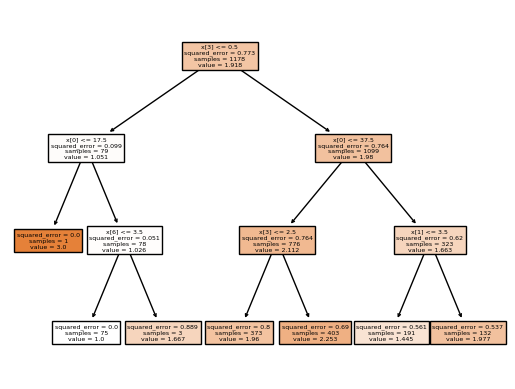

In [266]:
#3.3
model = tree.DecisionTreeRegressor(max_depth=3)
cart = model.fit(X_train, y_train)
predicted = cart.predict(X_test)
tree.plot_tree(cart,filled=True)


The values in the terminal nodes are 1,1.667,1.95,2.255,1.455, and 1.977. These values do not make sense because the values for method are either 1,2, or 3. A regression tree is usually used when what you are trying to predict is a continuous variable such as salary. However, method is a categorical variable. The regression tree is treating the method values as continuous instead of categorical, so it's giving the prediction as a probability instead of the hard value necessary.

Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

[Text(0.4230769230769231, 0.875, 'x[3] <= 0.5\ngini = 0.644\nsamples = 1178\nvalue = [508, 259, 411]'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 17.5\ngini = 0.049\nsamples = 79\nvalue = [77, 0, 2]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.23076923076923078, 0.375, 'x[6] <= 3.5\ngini = 0.025\nsamples = 78\nvalue = [77, 0, 1]'),
 Text(0.15384615384615385, 0.125, 'gini = 0.0\nsamples = 75\nvalue = [75, 0, 0]'),
 Text(0.3076923076923077, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [2, 0, 1]'),
 Text(0.6923076923076923, 0.625, 'x[1] <= 3.5\ngini = 0.652\nsamples = 1099\nvalue = [431, 259, 409]'),
 Text(0.5384615384615384, 0.375, 'x[0] <= 37.5\ngini = 0.609\nsamples = 676\nvalue = [324, 100, 252]'),
 Text(0.46153846153846156, 0.125, 'gini = 0.616\nsamples = 485\nvalue = [188, 75, 222]'),
 Text(0.6153846153846154, 0.125, 'gini = 0.451\nsamples = 191\nvalue = [136, 25, 30]'),
 Text(0.8461538461538461, 0.375, 'x[3] <= 2.5\ngini = 0.657\nsample

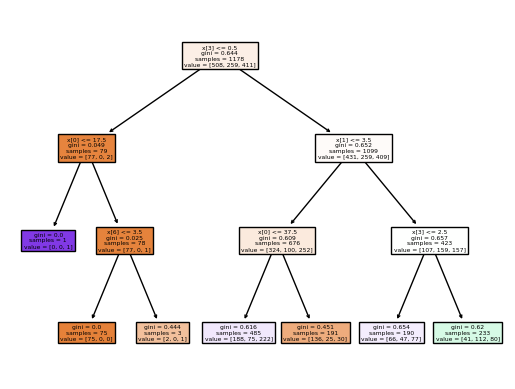

In [268]:
#3.4
model = tree.DecisionTreeClassifier(max_depth=3)
cart = model.fit(X_train, y_train)
predicted = cart.predict(X_test)
tree.plot_tree(cart,filled=True)

In [281]:
#3.5
tab = pd.crosstab(y_test,predicted)
pn(pd.crosstab(y_test,predicted))
acc = (50+32+77)/(50+13+58+10+32+32+3+20+77)
pn('Overall Accuracy: '+str(acc))

method_1 = 50/(50 + 13 + 58)
method_2 = 32/(10 + 32 + 32)
method_3 = 77/(3 + 20 + 77)

pn('Accuracy for Method 1: '+str(method_1))
pn('Accuracy for Method 2: '+str(method_2))
pn('Accuracy for Method 3: '+str(method_3))

col_0    1   2   3
method            
1       50  13  58
2       10  32  32
3        3  20  77 

Overall Accuracy: 0.5389830508474577 

Accuracy for Method 1: 0.4132231404958678 

Accuracy for Method 2: 0.43243243243243246 

Accuracy for Method 3: 0.77 



3.6)

For linear classification models, a threshold is set where if the probability of an event happening exceeds the threshold than the prediction is 1, otherwise the prediction is 0. If we have more than 2 categories, then the sum of probabilities across all the categories may not necessarily be 1 as each category's probability is calculated independently. The linear models would give order to values like 0,1, and 2, but these values are actually categorical placeholders.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?